In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import psutil
from sklearn.model_selection import train_test_split, RandomizedSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import numpy as np
import joblib
import os
import gc
from google.colab import files

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sklearn
sklearn.__version__

'1.5.2'

In [3]:
file_path = 'FibroPredCODIFICADA.xlsx'

try:
    df = pd.read_excel(file_path, header= 1)
    print(df.head())  # Display the first few rows of the DataFrame
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

print('Dimensio dataset:', df.shape)

   Pedigree     Sex FamilialvsSporadic COD NUMBER  Age at diagnosis  \
0         1    Male           Familial   13820545              70.0   
1         2    Male           Familial   12974225              66.0   
2         3    Male           Familial   13551148              59.0   
3         4  Female           Familial   13597482              66.0   
4         5    Male           Familial   10572432              72.0   

  Binary diagnosis  Final diagnosis  TOBACCO              Detail  \
0           No IPF                3        2  Tobacco-associated   
1           No IPF                8        2                 NaN   
2           No IPF                3        2  Tobacco-associated   
3              IPF                1        0          Organizing   
4              IPF                1        0                 NaN   

   Comorbidities  ...                   Type of family history  \
0              0  ...                                     CPFE   
1              1  ...           

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 77 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Pedigree                                       222 non-null    int64  
 1   Sex                                            222 non-null    object 
 2   FamilialvsSporadic                             222 non-null    object 
 3   COD NUMBER                                     222 non-null    object 
 4   Age at diagnosis                               221 non-null    float64
 5   Binary diagnosis                               222 non-null    object 
 6   Final diagnosis                                222 non-null    int64  
 7   TOBACCO                                        222 non-null    int64  
 8   Detail                                         66 non-null     object 
 9   Comorbidities                                  222 non

Pedigree                                          0.000000
Sex                                               0.000000
FamilialvsSporadic                                0.000000
COD NUMBER                                        0.000000
Age at diagnosis                                  0.450450
Binary diagnosis                                  0.000000
Final diagnosis                                   0.000000
TOBACCO                                           0.000000
Detail                                           70.270270
Comorbidities                                     0.000000
Radiological Pattern                              0.450450
Detail on NON UIP                                73.873874
Biopsy                                            1.351351
Pathology Pattern Binary                         57.657658
Pathology pattern UIP, probable or CHP           61.711712
Pathology pattern                                 2.252252
Extras AP                                        85.1351

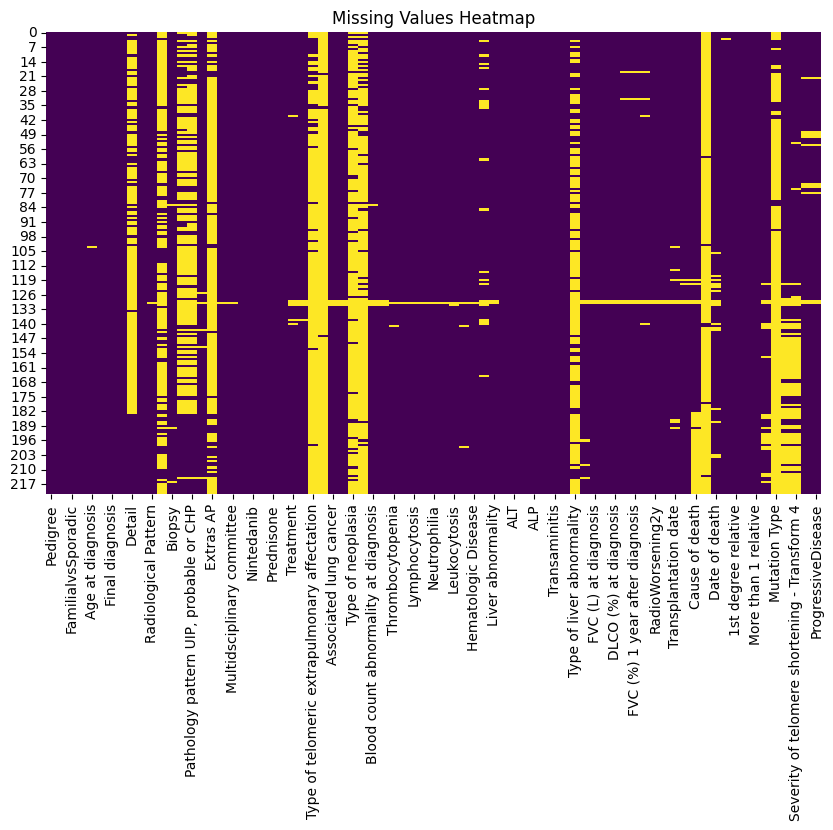

In [5]:
missing_values = (df.isnull().sum() / len(df)) * 100
missing_table = pd.DataFrame({'Column Name': missing_values.index, 'Missing Values': missing_values.values})
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(missing_values)

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [6]:


# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().sum() / len(df) * 100

# Identify columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index

# Create a new DataFrame without the identified columns
df = df.drop(columns=columns_to_drop)

# Display missing values in the new dataset
missing_values = (df.isnull().sum() / len(df)) * 100
print(missing_values)


Pedigree                                          0.000000
Sex                                               0.000000
FamilialvsSporadic                                0.000000
COD NUMBER                                        0.000000
Age at diagnosis                                  0.450450
Binary diagnosis                                  0.000000
Final diagnosis                                   0.000000
TOBACCO                                           0.000000
Comorbidities                                     0.000000
Radiological Pattern                              0.450450
Biopsy                                            1.351351
Pathology pattern                                 2.252252
Diagnosis after Biopsy                            0.450450
Multidsciplinary committee                        0.450450
Pirfenidone                                       0.000000
Nintedanib                                        0.000000
Antifibrotic Drug                                 0.0000

In [7]:
# Impute function
def impute_missing_values(df):
    """
    Imputes missing values in a DataFrame for numerical and categorical columns.
    Numerical columns are imputed with the median, and categorical columns are imputed with the mode.
    Float columns in numerical data are converted to integers.

    Args:
        df (pd.DataFrame): The input DataFrame with potential missing values.

    Returns:
        pd.DataFrame: The DataFrame with imputed values and transformed numerical columns.
    """
    # Separate numerical and categorical columns
    numerical_cols = df.select_dtypes(include=['number']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    # Impute numerical features with the median
    numerical_imputer = SimpleImputer(strategy='median')
    df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

    # Impute categorical features with the mode
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

    # Convert float columns to int (if applicable)
    for col in numerical_cols:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('int64')

    for column in df.columns:
      if df[column].dtype in ['int64', 'float64']:  # Només s'aplica a columnes numèriques
        moda = df[column][df[column] != -9].mode()
        if not moda.empty:
          moda_value = moda[0]
          df[column] = df[column].replace(-9, moda_value)

    return df

# Apply function
imputed_df = impute_missing_values(df)

# Display the updated DataFrame info
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 65 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   Pedigree                                       222 non-null    int64 
 1   Sex                                            222 non-null    object
 2   FamilialvsSporadic                             222 non-null    object
 3   COD NUMBER                                     222 non-null    object
 4   Age at diagnosis                               222 non-null    int64 
 5   Binary diagnosis                               222 non-null    object
 6   Final diagnosis                                222 non-null    int64 
 7   TOBACCO                                        222 non-null    int64 
 8   Comorbidities                                  222 non-null    int64 
 9   Radiological Pattern                           222 non-null    ob

In [8]:
# Drop specified columns
df = df.drop(columns=['Transplantation date', 'Date of death', 'Pedigree', 'COD NUMBER','Cause of death', 'ProgressiveDisease','Severity of telomere shortening - Transform 4', 'Treatment'])

# Replace '0' with 'No' in the 'pathology pattern' column
df['Pathology pattern'] = df['Pathology pattern'].replace('0', 'No')

In [9]:
# Extract all columns and their unique values in a tabular format
variables_summary = {col: df[col].unique() for col in df.columns}

# Create a summary DataFrame for better visualization
summary_df = pd.DataFrame({
    "Variable": variables_summary.keys(),
    "Options": [", ".join(map(str, values[:10])) + ("..." if len(values) > 10 else "") for values in variables_summary.values()]
})

# Display all options for each variable in a more comprehensive table format
full_summary = pd.DataFrame({
    "Variable": variables_summary.keys(),
    "Options": [", ".join(map(str, values)) for values in variables_summary.values()]
})

full_summary.reset_index(drop=True, inplace=True)

full_summary


,Variable,Options
0,Sex,"Male, Female"
1,FamilialvsSporadic,"Familial, Sporadic"
2,Age at diagnosis,"70, 66, 59, 72, 64, 49, 69, 60, 38, 47, 39, 36..."
3,Binary diagnosis,"No IPF, IPF"
4,Final diagnosis,"3, 8, 1, 9, 2, 5, 16, 4, 6, 11, 10, 12, 17, 18..."
5,TOBACCO,"2, 0, 1"
6,Comorbidities,"0, 1"
7,Radiological Pattern,"UIP, Probable UIP, Non UIP, Indeterminate UIP"
8,Biopsy,"0, 1, 2"
9,Pathology pattern,"0, Necrotizing vasculitis, UIP, Granulomatosis..."


In [10]:
# prompt: descarga en local un archivo .txt con las variables del summary en vertical y numeradas sin la columna options y sus valores

import pandas as pd

# Assuming 'full_summary' DataFrame is already created from the previous code

# Create a new DataFrame with only the 'Variable' column
variables_df = full_summary[['Variable']]

# Reset the index to start from 1
variables_df.index = variables_df.index + 1

# Convert the DataFrame to a string with numbered rows
variables_string = variables_df.to_string(index=True, header=False)

# Save the string to a text file
with open('variables_summary.txt', 'w') as f:
    f.write(variables_string)

# Download the file
from google.colab import files
files.download('variables_summary.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
# Convert 'Binary diagnosis' to binary integers (0 and 1)
df['Binary diagnosis'] = df['Binary diagnosis'].apply(
    lambda x: 1 if x.strip().lower() == "ipf" else 0
)

# Convert 'Death' to binary integers (0 and 1)
df['Death'] = df['Death'].apply(
    lambda x: 1 if x.strip().lower() == "yes" else 0
)

# Convert the target variables to a consistent format (e.g., string or numeric)
df['Death'] = df['Death'].astype(int)
df['Binary diagnosis'] = df['Binary diagnosis'].astype(int)
df['Necessity of transplantation'] = df['Necessity of transplantation'].astype(int)

# Recreate the target_variables DataFrame
target_variables = df[['Death', 'Binary diagnosis', 'Necessity of transplantation']]

# Display the new DataFrame with target variables
target_variables.head()


,Death,Binary diagnosis,Necessity of transplantation
0,1,0,0
1,0,0,0
2,0,0,1
3,1,1,0
4,0,1,0


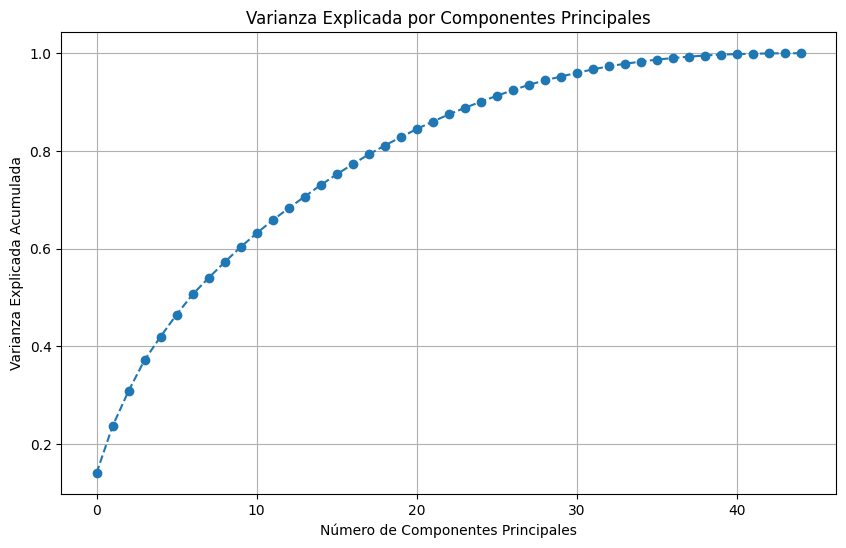

In [12]:
# Define target columns (replace with your actual target column names)
target_columns = ['Death', 'Binary diagnosis', 'Necessity of transplantation']
# Seleccionar columnas numéricas
numeric_data = df.select_dtypes(include=[np.number])

# Verificar que target_columns exista y esté limpia
target_columns = [col for col in target_columns if col in numeric_data.columns]
if not target_columns:
    raise ValueError("No valid target columns found in the dataset.")

# Normalización de las variables predictoras
scaler = StandardScaler()
predictors = numeric_data.drop(columns=target_columns, errors="ignore")
predictors_scaled = scaler.fit_transform(predictors)



from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(predictors_scaled)

# Graficar la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por Componentes Principales')
plt.grid(True)
plt.show()

In [13]:
# Número de componentes para cubrir el 95% de la varianza
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Número óptimo de componentes principales: {n_components}")
# Cargas de las variables originales en los componentes principales
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(len(pca.components_))],
    index=predictors.columns
)

loadings = loadings.iloc[:, :30]
# Mostrar las variables con menor contribución en los primeros componentes
print(loadings.head())  # Inspeccionar los valores para identificar variables poco importantes


Número óptimo de componentes principales: 30
                       PC1       PC2       PC3       PC4       PC5       PC6  \
Age at diagnosis -0.152315 -0.072770 -0.268480 -0.134863  0.034459 -0.207724   
Final diagnosis   0.094682 -0.005493  0.317522 -0.198636 -0.141642  0.128778   
TOBACCO          -0.073842 -0.008928 -0.089229  0.169795  0.050319  0.272674   
Comorbidities    -0.146969 -0.089426 -0.110199 -0.148576  0.057387 -0.137543   
Biopsy           -0.014814 -0.072214  0.027540 -0.082269 -0.008314  0.279152   

                       PC7       PC8       PC9      PC10      PC11      PC12  \
Age at diagnosis  0.227010  0.129526 -0.089595  0.012339 -0.019824  0.133057   
Final diagnosis   0.082807  0.092137 -0.056011  0.011127  0.054904 -0.138652   
TOBACCO          -0.254575  0.000569  0.042322  0.072011 -0.145094  0.105898   
Comorbidities     0.267559  0.228566 -0.067532  0.023086 -0.152939  0.160779   
Biopsy            0.130414  0.046511  0.135997  0.096688 -0.200281  0.4674

In [14]:
# Seleccionar variables con mayor contribución en los primeros componentes
threshold = 0.1  # Define un umbral de contribución (ajustar según sea necesario)
important_vars = loadings.apply(lambda x: any(abs(x) > threshold), axis=1)
predictors = predictors.loc[:, important_vars]

# Número y nombres de las variables seleccionadas
num_predictors = len(predictors.columns)
selected_columns = predictors.columns.tolist()

#Mostrar resultado
print(f"Number of predictors: {num_predictors}")
print(f"Variables seleccionadas: {predictors.columns.tolist()}")


Number of predictors: 44
Variables seleccionadas: ['Age at diagnosis', 'Final diagnosis', 'TOBACCO', 'Comorbidities', 'Biopsy', 'Diagnosis after Biopsy', 'Multidsciplinary committee', 'Pirfenidone', 'Nintedanib', 'Antifibrotic Drug', 'Prednisone', 'Mycophenolate', 'Extrapulmonary affectation', 'Associated lung cancer', 'Other cancer', 'Blood count abnormality at diagnosis', 'Anemia', 'Thrombocytopenia', 'Thrombocytosis', 'Lymphocytosis', 'Lymphopenia', 'Neutrophilia', 'Leukocytosis', 'Leukopenia', 'LDH', 'ALT', 'AST', 'ALP', 'GGT', 'Transaminitis', 'Cholestasis', 'FVC (L) at diagnosis', 'FVC (%) at diagnosis', 'DLCO (%) at diagnosis', 'FVC (L) 1 year after diagnosis', 'FVC (%) 1 year after diagnosis', 'DLCO (%) 1 year after diagnosis', 'RadioWorsening2y', '1st degree relative', '2nd degree relative', 'More than 1 relative', 'Genetic mutation studied in patient', 'Severity of telomere shortening', 'Progressive disease']


In [15]:
# prompt: descargar en local fichero .txt con selected_columns ordenadas en vertical y numeradas

import pandas as pd

# Assuming 'selected_columns' is defined as in your provided code
selected_columns = predictors.columns.tolist()  # Replace with your actual list

# Create a DataFrame for the selected columns
selected_columns_df = pd.DataFrame({'Column Name': selected_columns})

# Create the numbered vertical text output
output_text = ""
for i, col in enumerate(selected_columns_df['Column Name']):
    output_text += f"{i+1}. {col}\n"

# Save the output to a .txt file
with open('selected_columns.txt', 'w') as f:
    f.write(output_text)

# Download the file
from google.colab import files
files.download('selected_columns.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# Combine predictors and target columns to retain in the DataFrame
columns_to_keep = predictors.columns.tolist() + target_columns

# Filter the DataFrame to only include these columns
df = df[columns_to_keep]

print(df.head())

   Age at diagnosis  Final diagnosis  TOBACCO  Comorbidities  Biopsy  \
0                70                3        2              0       0   
1                66                8        2              1       0   
2                59                3        2              0       1   
3                66                1        0              1       1   
4                72                1        0              1       0   

   Diagnosis after Biopsy  Multidsciplinary committee  Pirfenidone  \
0                       1                           1            1   
1                       1                           1            1   
2                       1                           1            1   
3                       1                           1            1   
4                       1                           1            1   

   Nintedanib  Antifibrotic Drug  Prednisone  Mycophenolate  \
0           0                  1           0              0   
1           0       

In [17]:
'''def transform_dataframe_with_drop(df, split_column, columns_to_encode):
    """
    Transforms the dataframe by splitting a specified column into unique boolean columns,
    applying one-hot encoding to specified columns, converting boolean columns to binary,
    and dropping the original split column for clarity.

    Args:
        df (pd.DataFrame): The input dataframe.
        split_column (str): The column to split into unique values.
        columns_to_encode (list): List of columns to apply one-hot encoding.

    Returns:
        pd.DataFrame: The transformed dataframe.
    """
    # Split the specified column into unique boolean columns
    split_columns = df[split_column].str.get_dummies(sep=', ')

    # Add the new boolean columns back to the dataframe
    df_transformed = pd.concat([df, split_columns], axis=1)

    # Drop the original column for clarity
    df_transformed = df_transformed.drop(columns=[split_column])

    # Apply one-hot encoding to the specified columns
    df_transformed = pd.get_dummies(df_transformed, columns=columns_to_encode, drop_first=False)

    # Convert boolean columns to binary
    for col in df_transformed.columns:
        if df_transformed[col].dtype == 'bool':
            df_transformed[col] = df_transformed[col].astype(int)

    return df_transformed'''

'def transform_dataframe_with_drop(df, split_column, columns_to_encode):\n    """\n    Transforms the dataframe by splitting a specified column into unique boolean columns, \n    applying one-hot encoding to specified columns, converting boolean columns to binary,\n    and dropping the original split column for clarity.\n\n    Args:\n        df (pd.DataFrame): The input dataframe.\n        split_column (str): The column to split into unique values.\n        columns_to_encode (list): List of columns to apply one-hot encoding.\n\n    Returns:\n        pd.DataFrame: The transformed dataframe.\n    """\n    # Split the specified column into unique boolean columns\n    split_columns = df[split_column].str.get_dummies(sep=\', \')\n    \n    # Add the new boolean columns back to the dataframe\n    df_transformed = pd.concat([df, split_columns], axis=1)\n    \n    # Drop the original column for clarity\n    df_transformed = df_transformed.drop(columns=[split_column])\n    \n    # Apply one-hot

In [18]:
'''df_transformed = transform_dataframe_with_drop(
    selected_predictors,
    split_column="Type of family history",
    columns_to_encode=['Pathology pattern', 'Radiological Pattern', 'Hematologic Disease']
)'''

'df_transformed = transform_dataframe_with_drop(\n    selected_predictors, \n    split_column="Type of family history", \n    columns_to_encode=[\'Pathology pattern\', \'Radiological Pattern\', \'Hematologic Disease\']\n)'

In [19]:
'''# Display the first few rows of the transformed DataFrame
print(df_transformed.head())
print(df_transformed.info())'''

'# Display the first few rows of the transformed DataFrame\nprint(df_transformed.head())\nprint(df_transformed.info())'

In [20]:
'''# Save variables to a text file
with open('df_variables.txt', 'w') as f:
    for col in predictors.columns:
        f.write(f'{col}\n')

# Download the text file
from google.colab import files
files.download('df_variables.txt')'''

"# Save variables to a text file\nwith open('df_variables.txt', 'w') as f:\n    for col in predictors.columns:\n        f.write(f'{col}\n')\n\n# Download the text file\nfrom google.colab import files\nfiles.download('df_variables.txt')"

Optimizing models for target: Death
Memory Usage: 284.48 MB
 - Training model with Cross-Validation: RandomForest
Memory Usage: 284.48 MB
Mean Accuracy with Cross-Validation: 0.8427
Memory Usage: 284.60 MB
 - Training model with Cross-Validation: GradientBoosting
Memory Usage: 284.60 MB
Mean Accuracy with Cross-Validation: 0.8696
Memory Usage: 284.60 MB
 - Training model with Cross-Validation: SVM
Memory Usage: 284.60 MB
Mean Accuracy with Cross-Validation: 0.8923
Memory Usage: 284.60 MB
 - Training model with Cross-Validation: LogisticRegression
Memory Usage: 284.60 MB
Mean Accuracy with Cross-Validation: 0.8476
Memory Usage: 284.60 MB
 - Training model with Cross-Validation: DecisionTree
Memory Usage: 284.60 MB
Mean Accuracy with Cross-Validation: 0.8789
Memory Usage: 284.60 MB


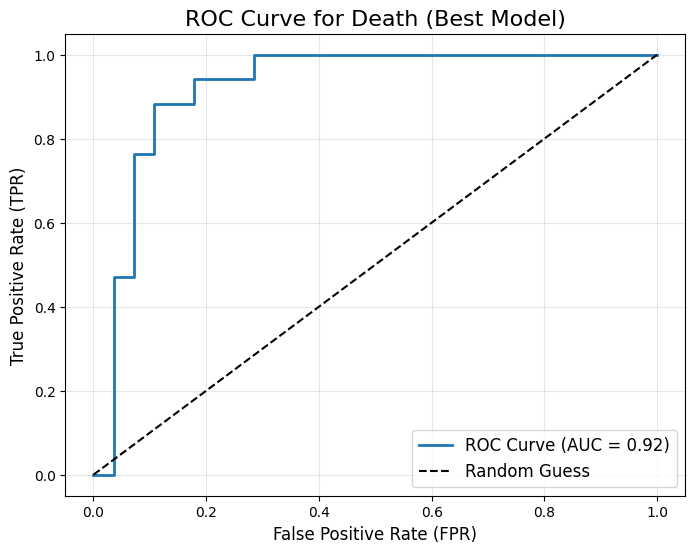

Learning Curve for Death (Best Model)


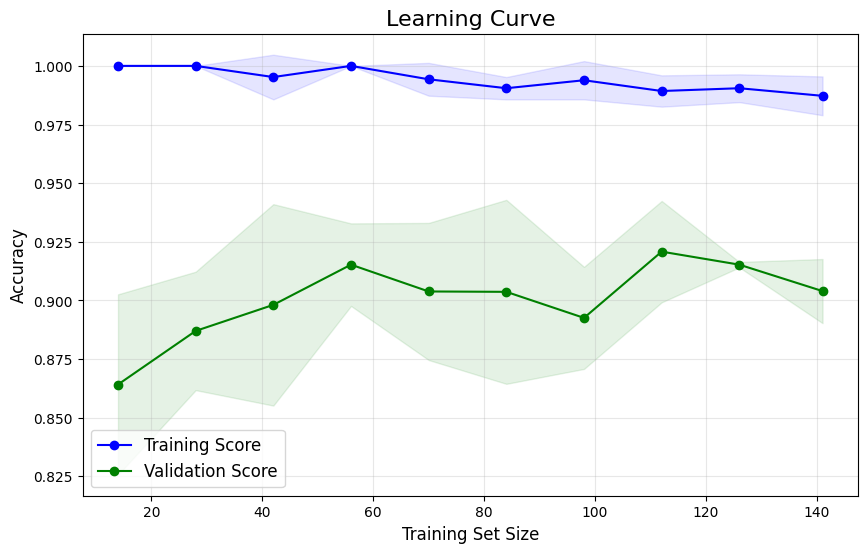

Memory Usage: 284.60 MB
Optimizing models for target: Binary diagnosis
Memory Usage: 284.61 MB
 - Training model with Cross-Validation: RandomForest
Memory Usage: 284.61 MB
Mean Accuracy with Cross-Validation: 0.9596
Memory Usage: 284.61 MB
 - Training model with Cross-Validation: GradientBoosting
Memory Usage: 284.61 MB
Mean Accuracy with Cross-Validation: 0.9911
Memory Usage: 284.61 MB
 - Training model with Cross-Validation: SVM
Memory Usage: 284.61 MB
Mean Accuracy with Cross-Validation: 0.8884
Memory Usage: 284.61 MB
 - Training model with Cross-Validation: LogisticRegression
Memory Usage: 284.61 MB
Mean Accuracy with Cross-Validation: 0.8794
Memory Usage: 284.61 MB
 - Training model with Cross-Validation: DecisionTree
Memory Usage: 284.61 MB
Mean Accuracy with Cross-Validation: 0.9911
Memory Usage: 284.61 MB


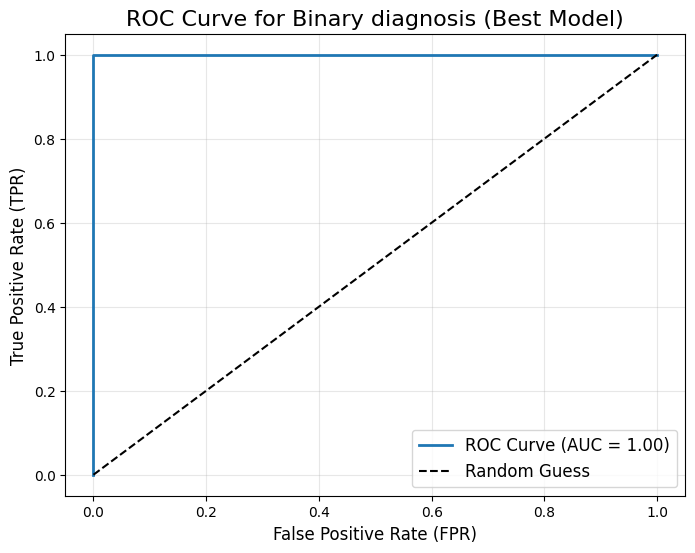

Learning Curve for Binary diagnosis (Best Model)


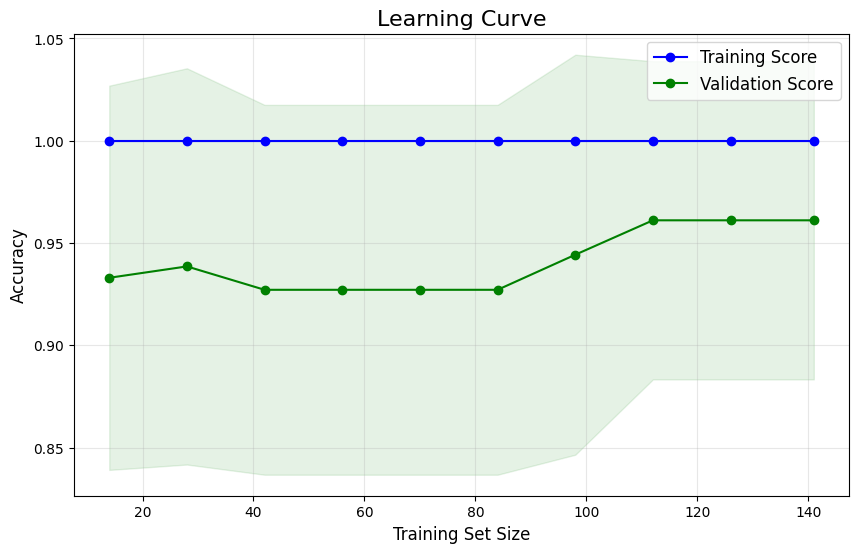

Memory Usage: 284.63 MB
Optimizing models for target: Necessity of transplantation
Memory Usage: 284.63 MB
 - Training model with Cross-Validation: RandomForest
Memory Usage: 284.63 MB
Mean Accuracy with Cross-Validation: 0.9052
Memory Usage: 284.63 MB
 - Training model with Cross-Validation: GradientBoosting
Memory Usage: 284.63 MB
Mean Accuracy with Cross-Validation: 0.9460
Memory Usage: 284.63 MB
 - Training model with Cross-Validation: SVM
Memory Usage: 284.63 MB
Mean Accuracy with Cross-Validation: 0.8383
Memory Usage: 284.63 MB
 - Training model with Cross-Validation: LogisticRegression
Memory Usage: 284.63 MB
Mean Accuracy with Cross-Validation: 0.8562
Memory Usage: 284.63 MB
 - Training model with Cross-Validation: DecisionTree
Memory Usage: 284.63 MB
Mean Accuracy with Cross-Validation: 0.9145
Memory Usage: 284.63 MB


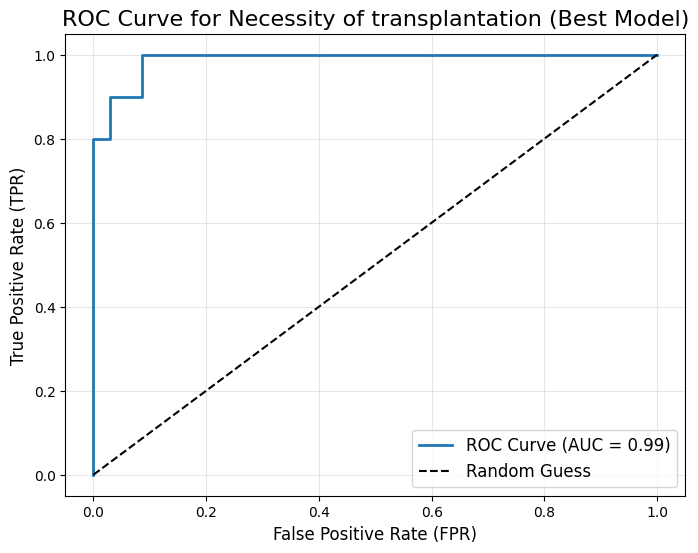

Learning Curve for Necessity of transplantation (Best Model)


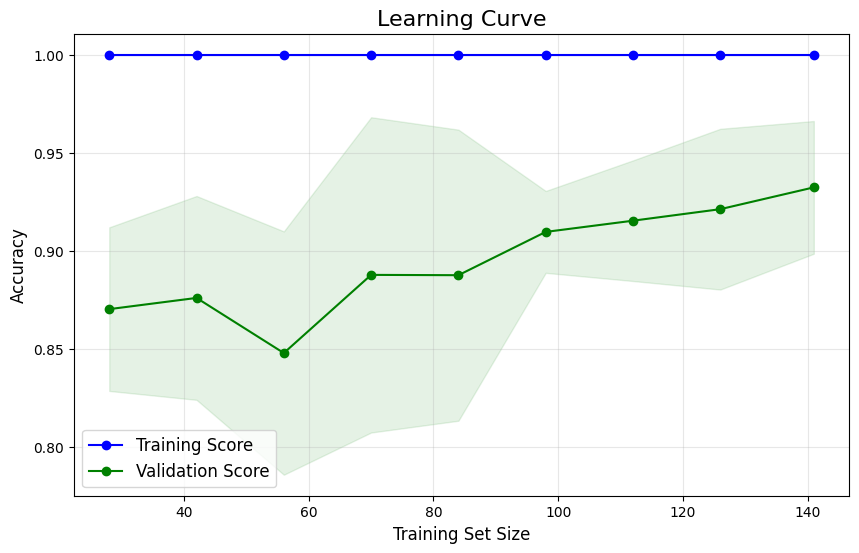

Memory Usage: 284.63 MB


In [41]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Función para graficar las curvas de aprendizaje
def plot_learning_curve(estimator, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Genera y grafica las curvas de aprendizaje para un modelo dado.

    Parameters:
        estimator: Modelo a evaluar.
        X: Matriz de características.
        y: Etiquetas.
        cv: Número de folds para validación cruzada.
        scoring: Métrica para evaluar ('accuracy', 'f1', etc.).
        train_sizes: Proporciones del conjunto de entrenamiento a usar.
    """
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=-1, random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', label='Training Score', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation Score', color='green')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')
    plt.title('Learning Curve', fontsize=16)
    plt.xlabel('Training Set Size', fontsize=12)
    plt.ylabel(scoring.capitalize(), fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Modificar el bucle para incluir las curvas de aprendizaje y ROC-AUC
for target in target_columns:
    print(f"Optimizing models for target: {target}")
    print_memory_usage()

    # Dividir datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(
        predictors_scaled, numeric_data[target], test_size=0.2, random_state=42
    )

    best_model = None
    best_params = None
    best_score = -np.inf
    best_report = None
    best_auc_score = 0
    best_fpr = None
    best_tpr = None

    for model_name, model in models.items():
        print(f" - Training model with Cross-Validation: {model_name}")
        print_memory_usage()

        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions[model_name],
            scoring='accuracy',
            cv=5,
            n_iter=10,
            n_jobs=-1,
            random_state=42
        )
        random_search.fit(X_train, y_train)

        best_candidate = random_search.best_estimator_
        scores = cross_val_score(best_candidate, predictors_scaled, numeric_data[target], cv=5, scoring='accuracy')
        mean_score = np.mean(scores)

        print(f"Mean Accuracy with Cross-Validation: {mean_score:.4f}")
        print_memory_usage()

        y_pred = best_candidate.predict(X_test)
        if hasattr(best_candidate, "predict_proba"):
            y_pred_proba = best_candidate.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc_score = roc_auc_score(y_test, y_pred_proba)

            if mean_score > best_score:
                best_model = best_candidate
                best_params = random_search.best_params_
                best_score = mean_score
                best_report = classification_report(y_test, y_pred, output_dict=True)
                best_auc_score = auc_score
                best_fpr = fpr
                best_tpr = tpr

    # Graficar ROC-AUC del mejor modelo
    if best_fpr is not None and best_tpr is not None:
        plt.figure(figsize=(8, 6))
        plt.plot(best_fpr, best_tpr, label=f'ROC Curve (AUC = {best_auc_score:.2f})', linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
        plt.title(f'ROC Curve for {target} (Best Model)', fontsize=16)
        plt.xlabel('False Positive Rate (FPR)', fontsize=12)
        plt.ylabel('True Positive Rate (TPR)', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(alpha=0.3)
        plt.show()

    # Graficar las curvas de aprendizaje del mejor modelo
    print(f"Learning Curve for {target} (Best Model)")
    plot_learning_curve(best_model, X_train, y_train, cv=5, scoring='accuracy')

    # Guardar resultados
    results[target] = {
        "best_model": best_model,
        "best_params": best_params,
        "best_score": best_score,
        "classification_report": best_report,
        "roc_auc_score": best_auc_score
    }

    print_memory_usage()
    del random_search, best_candidate, y_pred
    gc.collect()



In [22]:
# Function to save the best models
def save_best_models(results, output_dir="best_models"):
    """Saves the best models for each target variable.

    Args:
        results: A dictionary containing the results for each target variable.
        output_dir: The directory where the models will be saved.
    """

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for target, result in results.items():
        model_filename = os.path.join(output_dir, f"best_model_{target}.joblib")
        joblib.dump(result["best_model"], model_filename)
        print(f"Saved best model for {target} to {model_filename}")

# Function to load a saved model
def load_best_model(target, model_dir="best_models"):
    """Loads a saved model for a given target variable.

    Args:
        target: The name of the target variable.
        model_dir: The directory where the models are saved.
    Returns:
         The loaded model.
    """
    model_filename = os.path.join(model_dir, f"best_model_{target}.joblib")
    if os.path.exists(model_filename):
        loaded_model = joblib.load(model_filename)
        print(f"Loaded best model for {target} from {model_filename}")
        return loaded_model
    else:
        print(f"Error: Model file not found for {target} at {model_filename}")
        return None


# Save the best models after training
save_best_models(results)
'''
# Example of loading a saved model
loaded_death_model = load_best_model("Death")

if loaded_death_model:
    # Use the loaded model for predictions
    # Example:
    # new_data = ... # Your new data
    # predictions = loaded_death_model.predict(new_data)
    pass'''

Saved best model for Death to best_models/best_model_Death.joblib
Saved best model for Binary diagnosis to best_models/best_model_Binary diagnosis.joblib
Saved best model for Necessity of transplantation to best_models/best_model_Necessity of transplantation.joblib


'\n# Example of loading a saved model\nloaded_death_model = load_best_model("Death")\n\nif loaded_death_model:\n    # Use the loaded model for predictions\n    # Example:\n    # new_data = ... # Your new data\n    # predictions = loaded_death_model.predict(new_data)\n    pass'

<Figure size 1000x600 with 0 Axes>

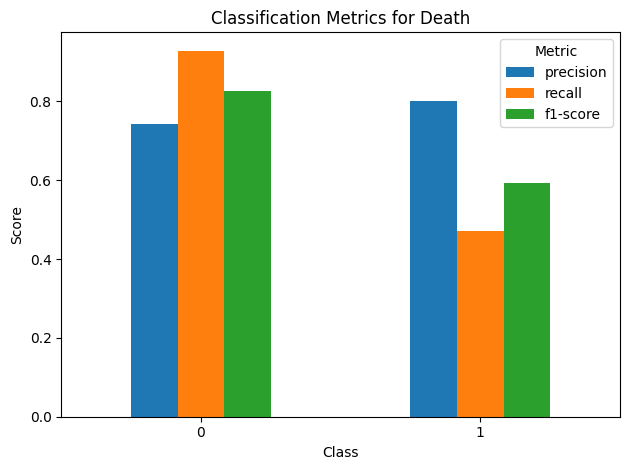

<Figure size 1000x600 with 0 Axes>

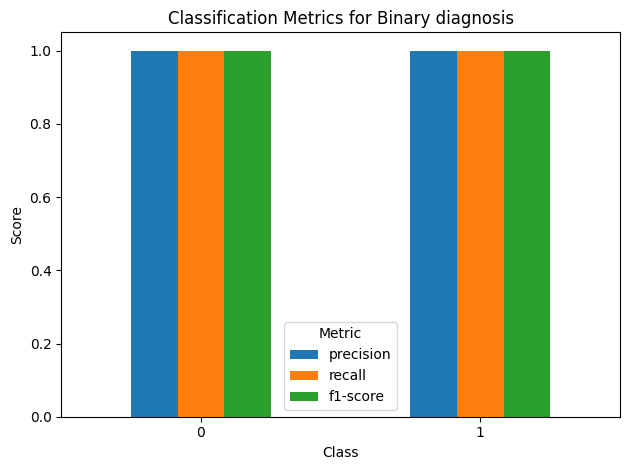

<Figure size 1000x600 with 0 Axes>

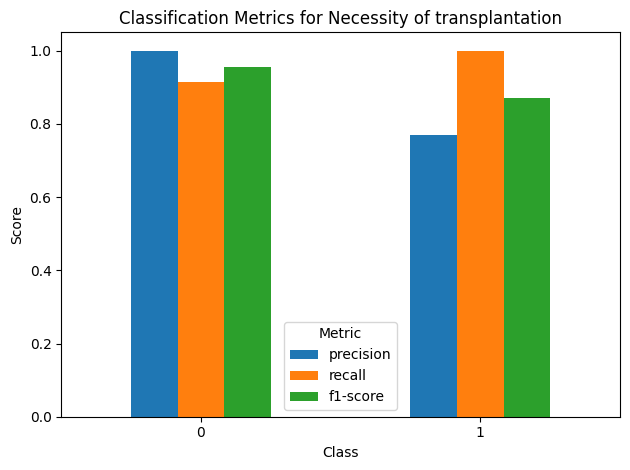

In [23]:
# Assuming 'results' dictionary is populated as in your previous code

for target, result in results.items():
    report = result['classification_report']

    # Extract precision, recall, and F1-score for each class
    metrics = {
        'precision': [report[cls]['precision'] for cls in report if isinstance(cls, str) and cls != 'accuracy' and cls != 'macro avg' and cls != 'weighted avg'],
        'recall': [report[cls]['recall'] for cls in report if isinstance(cls, str) and cls != 'accuracy' and cls != 'macro avg' and cls != 'weighted avg'],
        'f1-score': [report[cls]['f1-score'] for cls in report if isinstance(cls, str) and cls != 'accuracy' and cls != 'macro avg' and cls != 'weighted avg']
    }

    # Create a DataFrame for plotting
    metrics_df = pd.DataFrame(metrics, index=[cls for cls in report if isinstance(cls, str) and cls != 'accuracy' and cls != 'macro avg' and cls != 'weighted avg'])

    # Plotting
    plt.figure(figsize=(10, 6))
    metrics_df.plot(kind='bar', rot=0)
    plt.title(f'Classification Metrics for {target}')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

In [24]:
# Identify the predictors used for training
predictors = df.drop(columns=target_columns)

# Get the number of predictors
num_predictors = len(predictors.columns)

print(f"Predictors used for training: {predictors.columns.tolist()}")
print(f"Number of predictors: {num_predictors}")
print(f"Number of target variables: {predictors.columns.tolist()}")

Predictors used for training: ['Age at diagnosis', 'Final diagnosis', 'TOBACCO', 'Comorbidities', 'Biopsy', 'Diagnosis after Biopsy', 'Multidsciplinary committee', 'Pirfenidone', 'Nintedanib', 'Antifibrotic Drug', 'Prednisone', 'Mycophenolate', 'Extrapulmonary affectation', 'Associated lung cancer', 'Other cancer', 'Blood count abnormality at diagnosis', 'Anemia', 'Thrombocytopenia', 'Thrombocytosis', 'Lymphocytosis', 'Lymphopenia', 'Neutrophilia', 'Leukocytosis', 'Leukopenia', 'LDH', 'ALT', 'AST', 'ALP', 'GGT', 'Transaminitis', 'Cholestasis', 'FVC (L) at diagnosis', 'FVC (%) at diagnosis', 'DLCO (%) at diagnosis', 'FVC (L) 1 year after diagnosis', 'FVC (%) 1 year after diagnosis', 'DLCO (%) 1 year after diagnosis', 'RadioWorsening2y', '1st degree relative', '2nd degree relative', 'More than 1 relative', 'Genetic mutation studied in patient', 'Severity of telomere shortening', 'Progressive disease']
Number of predictors: 44
Number of target variables: ['Age at diagnosis', 'Final diagno

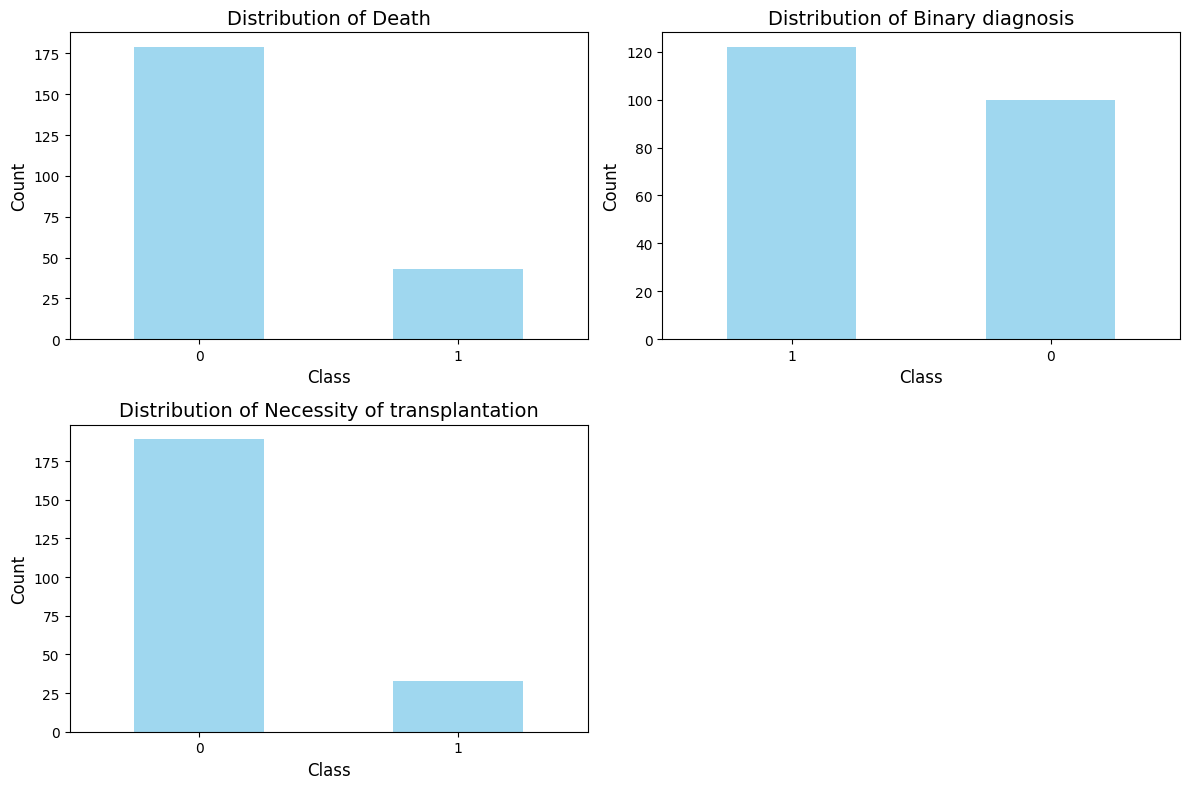

In [25]:
# Extract target columns from the data
target_data = numeric_data[target_columns]

# Plot the distribution of each target variable
plt.figure(figsize=(12, 8))
for i, target in enumerate(target_columns, start=1):
    plt.subplot(2, 2, i)
    target_data[target].value_counts().plot(kind='bar', color='skyblue', alpha=0.8)
    plt.title(f"Distribution of {target}", fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=0)
    plt.tight_layout()

plt.show()


In [26]:

def predict_with_model(input_data, target, model_dir="best_models"):
    """
    Fa una predicció utilitzant el model guardat i un diccionari d'entrada.

    Args:
        input_data: Diccionari amb les dades d'entrada per predir (variables categòriques).
        target: La variable objectiu ("Death", "Binary diagnosis" o "Necessity of transplantation").
        model_dir: El directori on es troben els models guardats.

    Returns:
        Predicció del model o None si hi ha un error.
    """
    # Comprovar si el target és vàlid
    valid_targets = ["Death", "Binary diagnosis", "Necessity of transplantation"]
    if target not in valid_targets:
        print(f"Error: El target '{target}' no és vàlid. Ha de ser un de: {valid_targets}")
        return None

    # Carregar el model
    model = load_best_model(target, model_dir=model_dir)
    if model is None:
        return None

    # Convertir el diccionari a DataFrame
    try:
        input_df = pd.DataFrame([input_data])
    except Exception as e:
        print(f"Error converting input data to DataFrame: {e}")
        return None

    # Fer la predicció
    try:
        prediction = model.predict(input_df)
        print(f"Prediction for target {target}: {prediction}")
        return prediction
    except Exception as e:
        print(f"Error making prediction: {e}")
        return None


In [27]:
def load_best_model(target, model_dir="best_models"):
    """Carrega un model guardat per una variable objectiu específica.

    Args:
        target: El nom de la variable objectiu ("Death", "Binary diagnosis", "Necessity of transplantation").
        model_dir: El directori on es troben els models guardats.

    Returns:
        El model carregat o None si hi ha un error.
    """
    model_filename = os.path.join(model_dir, f"best_model_{target}.joblib")
    if os.path.exists(model_filename):
        loaded_model = joblib.load(model_filename)
        print(f"Loaded best model for {target} from {model_filename}")
        return loaded_model
    else:
        print(f"Error: Model file not found for {target} at {model_filename}")
        return None


In [28]:


# Example input dictionary (replace with your actual input data)
input_data = {
    "Sex": "Male",
    "FamilialvsSporadic": "Familial",
    "Age at diagnosis": 70,
    "Final diagnosis": 3,
    "TOBACCO": 2,
    "Comorbidities": 0,
    "Biopsy": 0,
    "Diagnosis after Biopsy": -9,
    "Multidsciplinary committee": 1,
    "Pirfenidone": 1,
    "Nintedanib": 0,
    "Antifibrotic Drug": 1,
    "Prednisone": 0,
    "Mycophenolate": 0,
    "Extrapulmonary affectation": 0,
    "Associated lung cancer": 0,
    "Other cancer": 0,
    "Blood count abnormality at diagnosis": 0,
    "Anemia": 0,
    "Thrombocytopenia": 0,
    "Thrombocytosis": 0,
    "Lymphocytosis": 0,
    "Lymphopenia": 0,
    "Neutrophilia": 0,
    "Neutropenia": 0,
    "Leukocytosis": 0,
    "Leukopenia": 0,
    "Liver abnormality before diagnosis": "Yes",
    "Liver abnormality": "Yes",
    "LDH": 1,
    "ALT": 0,
    "AST": 0,
    "ALP": 0,
    "GGT": 0,
    "Transaminitis": 0,
    "Cholestasis": 0,
    "Liver disease": "No",
    "FVC (L) at diagnosis": 2,
    "FVC (%) at diagnosis": 79,
    "DLCO (%) at diagnosis": 43,
    "FVC (L) 1 year after diagnosis": 2,
    "FVC (%) 1 year after diagnosis": 67,
    "DLCO (%) 1 year after diagnosis": 27,
    "RadioWorsening2y": 1,
    "Cause of death": "Respiratory excerbation",
    "1st degree relative": 1,
    "2nd degree relative": 0,
    "More than 1 relative": 0,
    "Genetic mutation studied in patient": 1,
    "Severity of telomere shortening": 3,
    "Severity of telomere shortening - Transform 4": 6,
}


# Predicció per "Death"
result_death = predict_with_model(input_data, target="Death", model_dir="best_models")
print(f"Predicció per 'Death': {result_death}")

# Predicció per "Binary diagnosis"
result_diagnosis = predict_with_model(input_data, target="Binary diagnosis", model_dir="best_models")
print(f"Predicció per 'Binary diagnosis': {result_diagnosis}")

# Predicció per "Necessity of transplantation"
result_transplant = predict_with_model(input_data, target="Necessity of transplantation", model_dir="best_models")
print(f"Predicció per 'Necessity of transplantation': {result_transplant}")


Loaded best model for Death from best_models/best_model_Death.joblib
Error making prediction: could not convert string to float: 'Male'
Predicció per 'Death': None
Loaded best model for Binary diagnosis from best_models/best_model_Binary diagnosis.joblib
Error making prediction: could not convert string to float: 'Male'
Predicció per 'Binary diagnosis': None
Loaded best model for Necessity of transplantation from best_models/best_model_Necessity of transplantation.joblib
Error making prediction: could not convert string to float: 'Male'
Predicció per 'Necessity of transplantation': None


In [29]:
def download_models(model_dir="best_models"):
    """Downloads the saved models from the specified directory.

    Args:
        model_dir: The directory where the models are saved.
    """

    for filename in os.listdir(model_dir):
        if filename.startswith("best_model_"):
          filepath = os.path.join(model_dir, filename)
          if os.path.isfile(filepath):
              print(f"Downloading: {filename}")
              files.download(filepath) # Assuming you're in a Google Colab environment
          else:
              print(f"Skipping (not a file): {filename}")
    print("Download complete.")


# Call the function to download the models
download_models()

Downloading: best_model_Binary diagnosis.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: best_model_Death.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: best_model_Necessity of transplantation.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download complete.


In [30]:
from google.colab import files

def download_models(model_dir="best_models"):
    """Downloads the saved models from the specified directory.

    Args:
        model_dir: The directory where the models are saved.
    """
    for filename in os.listdir(model_dir):
        if filename.startswith("best_model_"):
            filepath = os.path.join(model_dir, filename)
            if os.path.isfile(filepath):
                print(f"Downloading: {filename}")
                files.download(filepath)  # Use Colab's download method
            else:
                print(f"Skipping (not a file): {filename}")
    print("Download complete.")

# Call the function to download the models
download_models()


Downloading: best_model_Binary diagnosis.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: best_model_Death.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: best_model_Necessity of transplantation.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download complete.
